# CAB420 DCNNs, Bonus Example: Tensflow Dataset API
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

This is, more of less, my quick start guide to tensorflow datasets. If you're here, it's also going to be worth having a look at the [documentation on all this too](https://www.tensorflow.org/datasets).

Before we dive in, why TFDS? Datasets can be big. In CAB420, generally we use small datasets that fit into memory easily, however often this is not possible. When dealing with large datasets, a popular approach is to stream the data from disk, only storing in memory what's needed for the next batch (or few batches). There are lots of ways to do this, and the tensorflow datasets API is one such way.

### Where does this fit into all the other CAB420 content?

This is (probably) going to be of most use for those of you wanting to use TFDS for Assignment 2; or just wanting to explore other weird and wonderful datasets. We're not looking at any funky DCNN addons in this, it really is just about getting data into models.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import cv2

### Loading a Dataset

This will load the dataset. The first time you run it, it will actually download it for you (like Keras does with Fashion MNIST) as well.

There's a few key things going in terms of what I ask of `tfds.load`. In particular:
* The dataset name. TFDS has a [lot of datasets](https://www.tensorflow.org/datasets/catalog/overview#all_datasets), I need to tell it which one to load
* How I want the data split. What I have asked for here is three splits, which will be the first 90% of the training data, the last 10% of the training data and all of the test data. For this to work, I need to make sure that my dataset actually has train and test splits. Luckily, there is [documentation for each dataset which tells me these things](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors).
* Setting `as_supervised=True`. This seems innocuous, but does really change what I get back. With this as `True`, the returned dataset is made of up 2-tuples of (sample, label), which probably seems pretty logical. If this is `False`, you'll get a dictionary of all the features, which is generally less useful.

In [2]:
(ds_train, ds_val, ds_test), ds_info = tfds.load('rock_paper_scissors',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
print(ds_train)

<PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


I've loaded a dataset. Now what? This isn't in friendly numpy arrays, and working with the data is not as intuitive as if it's all just in one great big array. In particular, the thing that I love to do - sanity checks - are not as obvious here. But I can pull out the size of the dataset, and there is an inbuilt function to draw some pictures (note, `show_examples` will only work for image type datasets).

2268


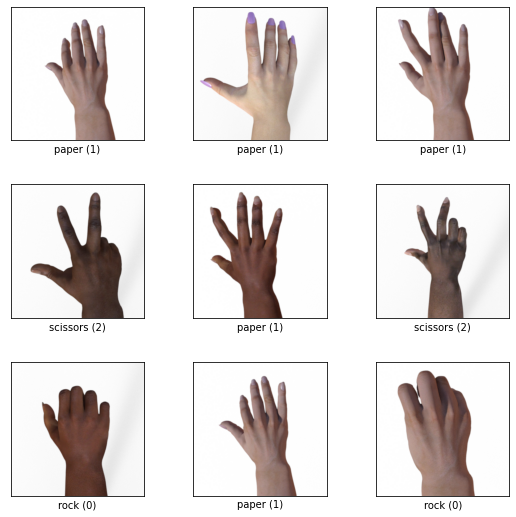

In [3]:
print(ds_train.cardinality().numpy())
fig = tfds.show_examples(ds_train, ds_info)

I could do the same thing (get size, draw pictures) for the validation and test sets.

## Working with TFDS

We've loaded data. Now what. How do we get this into a DCNN and actually do stuff. Turns out there are a few options. Let's look at them.

### Option 1: Load from TFDS, and then Convert to Numpy

**USE THIS OPTION WITH CAUTION**: If you have a large dataset, this approach is a poor choice. It will load the entire dataset into memory, which for a big dataset will go badly. One the advantages of TFDS is that is only stores in memory what is needed at the time. This allows us to work with huge datasets that wouldo otherwise not be possible.

We did this before in an earlier example, and I glossed over what was going on. We'll look in more detail here. What I'm going to do is:
* Load the data with TFDS, pulling out just the train and test splits
* Convert that data to numpy, getting an `x` and `y` array for the train and test splits, like we're used to using

My `load_tfds` function is hopefully fairly straight foward and obvious, but `convert_to_numpy` deserves a bit more of a look. These datasets are iterable, so all we're going to do is iterate through, and pull out each sample, dumping them in a list. Behind the scenes, this will actually be loading the data from disk as we go. Once we've got our lists, we'll convert them to numpy arrays, and then apply some scaling to our images to get them into the range [0..1]. 

Finally, I have a little function to resize the dataset. These images are $300\times300$ pixels, which is a bit bigger than I want to deal with here. 

In [4]:
# convert the contents of a tfds to a couple of numpy arrays
def convert_to_numpy(ds):
    
    x = []
    y = []
    # loop through the dataste
    for im,l in ds:
        # add the images and their labels to x and y lists
        x.append(im)
        y.append(l)

    # convert lists to arrays
    x = np.array(x)
    y = np.array(y)
    # convert the images to a float, and scale by 1/255
    x = (x.astype(np.float32) / 255.0)
    
    # return the newly converted x and y
    return x, y

# load a tdfs dataset, and convert it to numpy
def load_tfds(dataset):
    # load the data
    (ds_train, ds_test), ds_info = tfds.load(
        dataset,
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )

    # convert to numpy
    x_train, y_train = convert_to_numpy(ds_train)
    x_test, y_test = convert_to_numpy(ds_test)

    # return the numpy version of the data
    return (x_train, y_train), (x_test, y_test)

def resize_dataset(images, target_size):
    
    resized_images = []
    for im in images:
        resized_images.append(cv2.resize(im, target_size))
    
    return np.array(resized_images)

Then, we can print out shapes of data, draw pictures, and do the usual fun things in the usual manner.

(2520, 100, 100, 3)
(2520,)
(372, 100, 100, 3)
(372,)


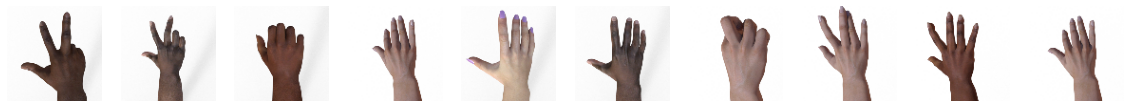

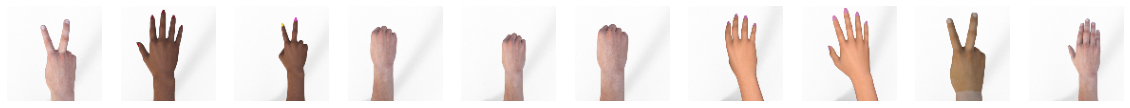

In [5]:
# pictures, lots of pictures
def display_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, :], cmap='gray')
        ax[i].axis('off')
    plt.show()

# load the data
(x_train, y_train), (x_test, y_test) = load_tfds('rock_paper_scissors')
x_train = resize_dataset(x_train, (100, 100))
x_test = resize_dataset(x_test, (100, 100))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# display the first 10 images of the train and test sets
display_images(x_train, 10)
display_images(x_test, 10)

At this point, we're very much in what should be familar territory, and we can just train a network as we usually would. For sake of completeness, we'll do that here. 

In [6]:
def get_simple_network():
    inputs = keras.Input(shape=(100, 100, 3, ), name='img')
    # starting with a 7x7 conv and 4x4 max pooling given the larger input image size, and a desire to avoid
    # having too many layers. This is a simple problem and I don't need a big network, so I can get away
    # with this sort of thing here.
    x = layers.Conv2D(filters=8, kernel_size=(7,7), activation='relu', padding='same')(inputs)
    x = layers.MaxPool2D(pool_size=(4, 4))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    # build the model, and print the summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='rps')
    return model_cnn

model_cnn = get_simple_network()
model_cnn.summary()

Model: "rps"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 8)       1184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        4640    

Epoch 1/5
126/126 [==============================] - 9s 23ms/step - loss: 0.5623 - accuracy: 0.7361 - val_loss: 0.0947 - val_accuracy: 0.9683
Epoch 2/5
126/126 [==============================] - 3s 22ms/step - loss: 0.0248 - accuracy: 0.9940 - val_loss: 0.0167 - val_accuracy: 0.9960
Epoch 3/5
126/126 [==============================] - 3s 24ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 0.0197 - val_accuracy: 0.9960
Epoch 4/5
126/126 [==============================] - 3s 24ms/step - loss: 0.0313 - accuracy: 0.9901 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 5/5
12/12 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       124
           1       0.84      0.88      0.86       124
           2       0.91      0.87      0.89       124

    accuracy                           0.91       372
   macro avg       0.91      0.91      0.91       372
weighted avg       0.91      0.91      0.9

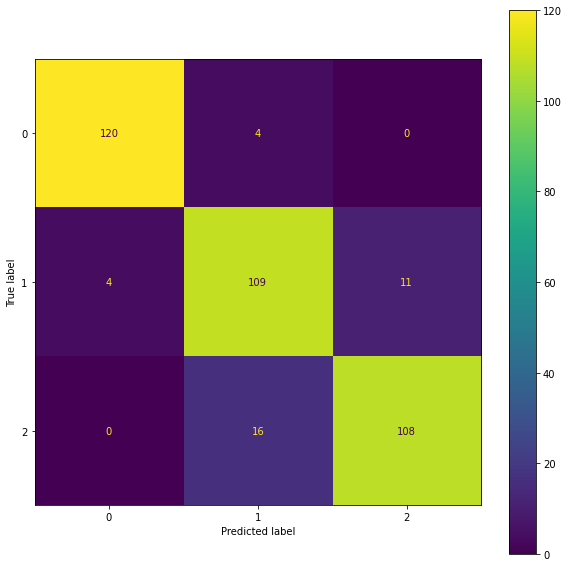

In [7]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
history = model_cnn.fit(x_train, y_train,
                        batch_size=16,
                        epochs=5,
                        validation_split=0.2)

def eval_model(model, x_test, y_test):
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(3))
    c.plot(ax = ax)

    print(classification_report(y_test, indexes))

eval_model(model_cnn, x_test, y_test)

### Option 2: Working with the TFDS Dataset as is

Let's now go again, but we'll leave our data in the TDFS object this time. 

What we'll do is:
* Load the data, doing the split into train, val and test in that process
* Create some operations to scale our data, and resize it 100,100
* Apply this operation to our data sets

When we setup our datasets, we'll also specify the batch size to prepare these to send batches to our network.

In [8]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# load the data
(ds_train, ds_val, ds_test), ds_info = tfds.load('rock_paper_scissors',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# resize and rescaling operations
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(100, 100),
  layers.Rescaling(1./255)
])

# apply resizing and rescaling to the data, then set the batch size. The "num_parallel_calls=AUTOTUNE" is used
# to tell tensorflow to optimise prefetching alongside other operations so all runs smoothly.
ds_train_small = ds_train.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE).batch(batch_size)
ds_val_small = ds_val.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE).batch(batch_size)
ds_test_small = ds_test.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE).batch(batch_size)

We can then just train our network, and rather than pass in x and y data, we just pass in the dataset.

In [9]:
model_cnn = get_simple_network()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
history = model_cnn.fit(ds_train_small,
                        batch_size=batch_size,
                        epochs=5,
                        validation_data=ds_val_small)

Epoch 1/5
142/142 [==============================] - 7s 40ms/step - loss: 0.5294 - accuracy: 0.7584 - val_loss: 0.1613 - val_accuracy: 0.9444
Epoch 2/5
142/142 [==============================] - 5s 32ms/step - loss: 0.0462 - accuracy: 0.9881 - val_loss: 0.0412 - val_accuracy: 0.9881
Epoch 3/5
142/142 [==============================] - 5s 32ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.0235 - val_accuracy: 0.9921
Epoch 4/5
142/142 [==============================] - 4s 27ms/step - loss: 0.0197 - accuracy: 0.9929 - val_loss: 0.0542 - val_accuracy: 0.9921
Epoch 5/5
142/142 [==============================] - 6s 43ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 5.1650e-04 - val_accuracy: 1.0000


We can even pass the dataset into our evaluation function, though we need to be a bit more creative with how get the y labels.

24/24 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       124
           1       0.88      0.79      0.83       124
           2       0.92      0.88      0.90       124

    accuracy                           0.89       372
   macro avg       0.89      0.89      0.89       372
weighted avg       0.89      0.89      0.89       372



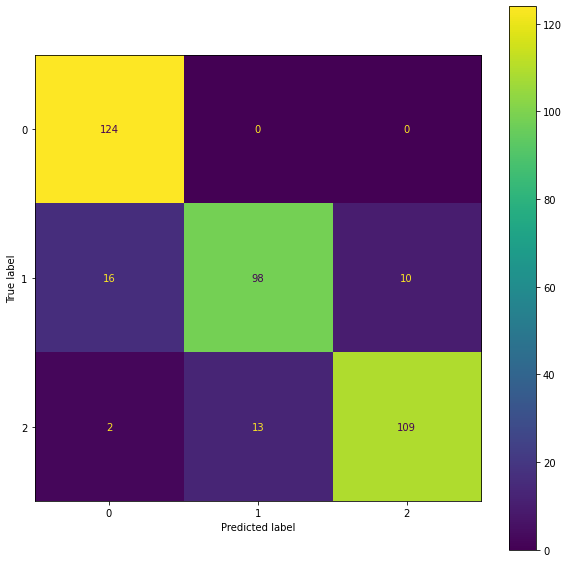

In [10]:
def eval_model_ds(model, test):
    # pass dataset directly into predict
    pred = model.predict(test);
    # do the usual thing to get the actual predictions rather than the softmax scores
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)

    # pull out the labels. Here we loop throuhg all the data, and just concatenate the y values,
    # ditching the x values
    y_test = tf.concat([y for x, y in test], axis=0)

    # and now we have our usual predictions and labels, and all is good
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(3))
    c.plot(ax = ax)

    print(classification_report(y_test, indexes))
    
eval_model_ds(model_cnn, ds_test_small)

#### Augmentation, and Cleaning it Up

We'll now make this a bit more full featured, and clean it up a bit more. We'll also in augmentation.

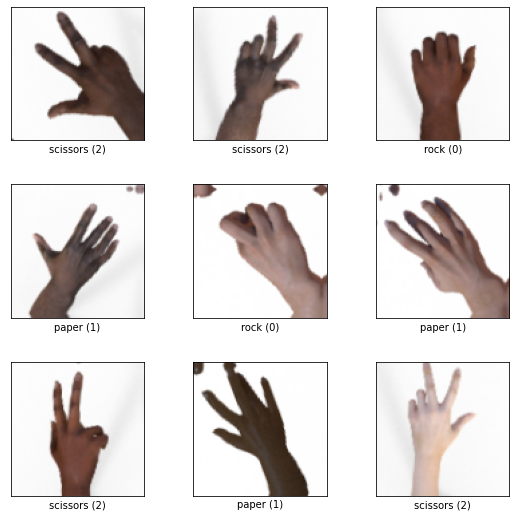

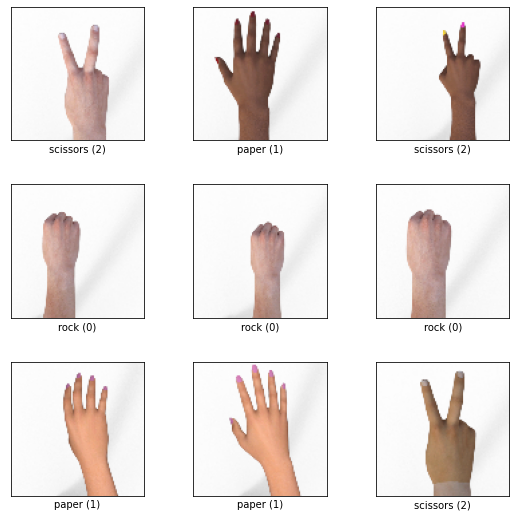

In [11]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# load the data
(ds_train, ds_val, ds_test), ds_info = tfds.load('rock_paper_scissors',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# resize and rescaling operations
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(100, 100),
  layers.Rescaling(1./255)
])

# augmentation operations
augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom((-0.1, 0.1)),
])

# function to apply rescaling and augmentation (if wanted)
def prepare_ds(ds, augment=False):

    # apply preprocessing (resizing and rescale)
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only if requested
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    return ds

# function to apply batching and prefecting
# This could very easily be part of the "prepare_ds" function, but you can't call show exmaples
# on batched data
def batch_and_prefetch(ds):       
    # batch the dataset
    ds = ds.batch(batch_size)
    
    # use buffered prefetching
    return ds.prefetch(buffer_size=AUTOTUNE)

# Use augmentation for training data only
ds_train = prepare_ds(ds_train, True)
ds_val = prepare_ds(ds_val, False)
ds_test = prepare_ds(ds_test, False)

# show examples, should have augmentation visible in the training data, but not the
# testing data
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

# batch and pre-fetch
ds_train = batch_and_prefetch(ds_train)
ds_val = batch_and_prefetch(ds_val)
ds_test = batch_and_prefetch(ds_test)

Epoch 1/5
142/142 [==============================] - 7s 43ms/step - loss: 0.3615 - accuracy: 0.8496 - val_loss: 0.1054 - val_accuracy: 0.9444
Epoch 2/5
142/142 [==============================] - 5s 32ms/step - loss: 0.0549 - accuracy: 0.9828 - val_loss: 0.0295 - val_accuracy: 0.9921
Epoch 3/5
142/142 [==============================] - 7s 46ms/step - loss: 0.0185 - accuracy: 0.9934 - val_loss: 0.0308 - val_accuracy: 0.9921
Epoch 4/5
142/142 [==============================] - 8s 56ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/5
24/24 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       124
           1       0.98      0.75      0.85       124
           2       0.89      0.94      0.91       124

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.89       372
weighted avg       0.90      0.90      0.89

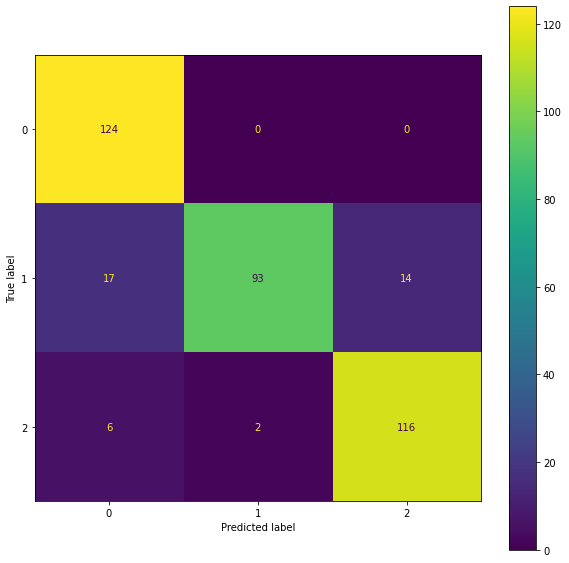

In [12]:
# train and evaluate the model
model_cnn = get_simple_network()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
history = model_cnn.fit(ds_train_small,
                        batch_size=batch_size,
                        epochs=5,
                        validation_data=ds_val_small)
eval_model_ds(model_cnn, ds_test_small)

## Final Thoughts

There's not a lot more to add here. Hopefully from the above, you have some idea of how you can use the tensorflow data API to quickly load and manage larger datasets. Working with your own datasts that aren't already in TFDS requires a bit more wrangling which is not covered here.